# Example: How to use models, pipeline and inspection together to 1. represent the formation of a scattering image in consecutive calculation steps and 2. store interim results for later contemplation

In this example, a sharp circular 2D density is created. The detector image from scattering at this density is then calculated using a non-flat illumination function.

**Tasks:**
1. write a model functor that
     * creates a 2D image of a circle in a given 2D domain
     * taking its position an radius as parameters
     * comlies to the BaseModel interface
2. use the classes in InspectObjective to make one functor for each of those:
     * saving the 2D density image of the circle
     * saving the illumination function
     * saving the scattering image
3. create a pipeline that represents the formation of the scattering image
     * starting with
         * the parameters for the circle and the illumination function
         * no interim results
         * the (constant) 2D domain in real space
     * saving the desired interim results
4. set up a 2D domain and parameters for testing
5. calculate the scattering image using the pipeline
6. inspect the saved interim results

In [1]:
from mysticetus import Models           as Md   # Interface and some functors for "atomic" scattering image calculation steps
from mysticetus import InspectObjective as IO   # Functors for saving stuff right after a calculation step has finished
from mysticetus import Objective as Ob          # Interface for representing a whole scattering image formation

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# 1. Model functor

In [2]:
class CreateCircleImage(Md.BaseModel):
    """
    Model for a cirlce.
    """
    def calc(self, params, interims, consts):
        """
        Do the significant calculations and store results in interims.
        """
        # unpack params
        radius  =   params['radius']
        posx    =   params['posx']
        posy    =   params['posy']
        
        # unpack consts
        xx      =   consts['domain']['xx']
        yy      =   consts['domain']['yy']
        
        # do calculation
        density =   (xx-posx)**2 + (yy-posy)**2 <= radius**2
        
        # store for following steps
        interims['dist'] =\
                    density     # interims['dist'] is where following steps
                                # (the ones defined in Models.py) expect the
                                # scattering density

# 2. Functors for saving

In [3]:
class SaveObject:
    """
    Stores saved results as attributes.
    """
    pass

# Create relevant objects so their names are known to python
so        = SaveObject()
params    = {}
interims  = {}
consts    = {}

# Functor object for saving circle density
save_circle =\
            IO.GetSet(
                IO.DeepCopyKeyGetter(interims, 'dist'),
                IO.AttributeSetter(so, 'circleDensity')
            )

# Functor object for saving illumination function
save_illumination =\
            IO.GetSet(
                IO.DeepCopyKeyGetter(interims, 'illumination'),
                IO.AttributeSetter(so, 'illuminationFunction')
            )

# Functor object for saving scattering image
save_scattering =\
            IO.GetSet(
                IO.DeepCopyKeyGetter(interims, 'meas'),
                IO.AttributeSetter(so, 'circleScattered')
            )

# 3. Image formation pipeline

In [4]:
pl = Ob.Pipeline([
    CreateCircleImage(                 save=save_circle),
    Md.CreateIllumination(             save=save_illumination),
    Md.MultDistWithInterimIllumination(),
    Md.MeasModelFarFieldIntensity2D(   save=save_scattering),
])

# 4. Set up test

In [5]:
xmin  = 23.
xmax  = 24.
xres  = 64

ymin  = 76.
ymax  = 77.
yres  = 64

x     = np.linspace(xmin, xmax, xres, endpoint=False)
y     = np.linspace(ymin, ymax, yres, endpoint=False)
xx, yy =\
        np.meshgrid(x, y)

consts['domain']  = {'xx':xx, 'yy':yy}
params['radius']  = 0.15    # same units as xmin, ymax etc.
params['posx']    = 23.25   # same units as xmin, ymax etc.
params['posy']    = 76.6    # same units as xmin, ymax etc.
params['sill']    =  8      # unit: 1 px -> same as xres, yres

# 5. Calculate scattering image

In [6]:
pl(params, interims, consts)

# 6. Inspect what was saved

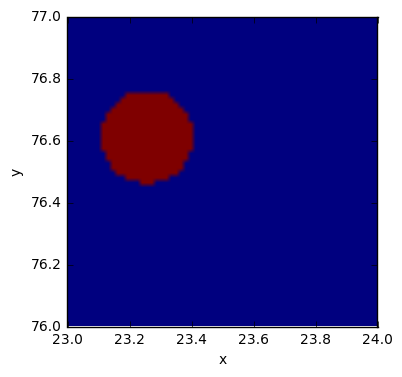

In [7]:
plt.imshow(so.circleDensity, origin='lower', extent=[xmin, xmax, ymin, ymax])
plt.xlabel('x')
plt.ylabel('y')

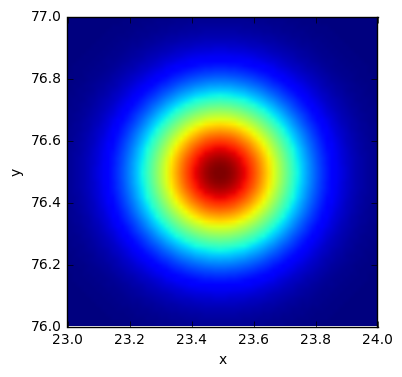

In [8]:
plt.imshow(so.illuminationFunction, origin='lower', extent=[xmin, xmax, ymin, ymax])
plt.xlabel('x')
plt.ylabel('y')

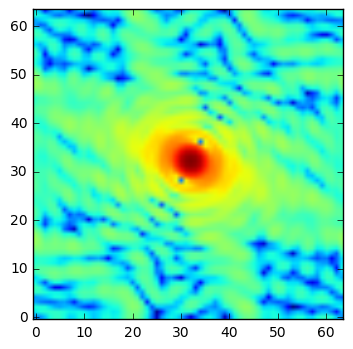

In [9]:
plt.imshow(np.log(so.circleScattered), origin='lower')